In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math as math
import pandas as pd

In [ ]:
# Our SEIAVRD Model

j = 1 # Choose subpopulation 1-5
t_max = 150 #Choose time interval

In [ ]:
i_datalist = np.zeros(5)
d_datalist = np.zeros(5)
N_list = np.zeros(5)
r_votes_list = np.zeros(5)

# 0 cumulative cases by population
i_datalist[0] = 1.65e6
i_datalist[1] = 1.12e7
i_datalist[2] = 5.55e6
i_datalist[3] = 0.74e7
i_datalist[4] = 1.85e6

# 0 cumulative deaths by population
d_datalist[0] = 32300
d_datalist[1] = 195000
d_datalist[2] = 90000
d_datalist[3] = 127500
d_datalist[4] = 35500

r_votes_list[0] = .2 # % of 2020 trump votes
r_votes_list[1] = .4
r_votes_list[2] = .5
r_votes_list[3] = .7
r_votes_list[4] = .9

r_votes = r_votes_list[j-1]
# r_votes = .35 # or hard code specific value

i_data = i_datalist[j-1] # 0 cumulative cases in population of interest
d_data = d_datalist[j-1] # 0 cumulative deaths in population of interest

rho = 0.12112112112112113 # scaling factor for transmission rate estimation



# parameter values
t_incubation = 2.8 #time from exposed to to infected
v_incubation = 10.17 #time from vaccinated to vaccine activation, weighted average of pfizer, moderna, johnson&johnson
r_time = 9 #average covid recovery time
alpha = .92 # vaccine efficacy against infection, weighted average of pfizer, moderna, johnson&johnson

N_list[0] = 29086766 #a1 0 population
N_list[1] = 131505862 #a2 0 population
N_list[2] = 62118607 #a3 0 population
N_list[3] = 83475174 #a4 0 population
N_list[4] = 19371663 #a5 0 population

N_tot = np.sum(N_list)

N = N_list[j-1] #population of interest

In [ ]:

prop = (.553*N_list[0]+.531*N_list[1]+.490*N_list[2]+.422*N_list[3]+.347*N_list[4])/(N_list[0]+N_list[1]+N_list[2]+N_list[3]+N_list[4])

b = 0 # vaccination proportion by state/county
beta = 1/t_incubation # rate of emigration from exposed
gammai = rho/N # rate of susceptibles exposed by infected
gammaa = .8*gammai # rate of susceptibles exposed by asymptomatic
gammavi = (1-alpha)*gammai
gammava = (1-alpha)*gammaa
mu_c = .00189 # death rate from infection without effective vaccination
mu = 715.2/100000 # natural death rate
nu = 0.0024988264652203583/prop # vaccination rate
lambdaa = 1/r_time # rate of asymptomatic to recovered
lambdai = 1/r_time # rate of infected to recovered
phi = 1/v_incubation # rate of vaccine activation
sigma = .35 # ratio of asymptomatic cases to all cases
theta = 11/1000*N # natural birth rate

if r_votes < .25:
  b = .553

elif .25 <= r_votes < .45:
  b = .531
elif .45 <= r_votes < .55:
  b = .490
elif .55 <= r_votes < .75:
  b = .422
else:
  b = .347




params = [b, beta, gammaa, gammai, gammava, gammavi, lambdaa, lambdai, mu, mu_c, nu, phi, sigma, theta]

# 0 number of infected and recovered individual
i0 = i_data/350*1.994
a0 = i0*sigma/(1-sigma)*5.72/1.994
e0 = (a0+i0)*t_incubation
v0 = .1*N
r0 = 0
d0 = d_data #cumulative total dead
c0 = i_data #cumulative total symptomatic to fit to data
s0 = N - e0 - i0 - v0 - r0

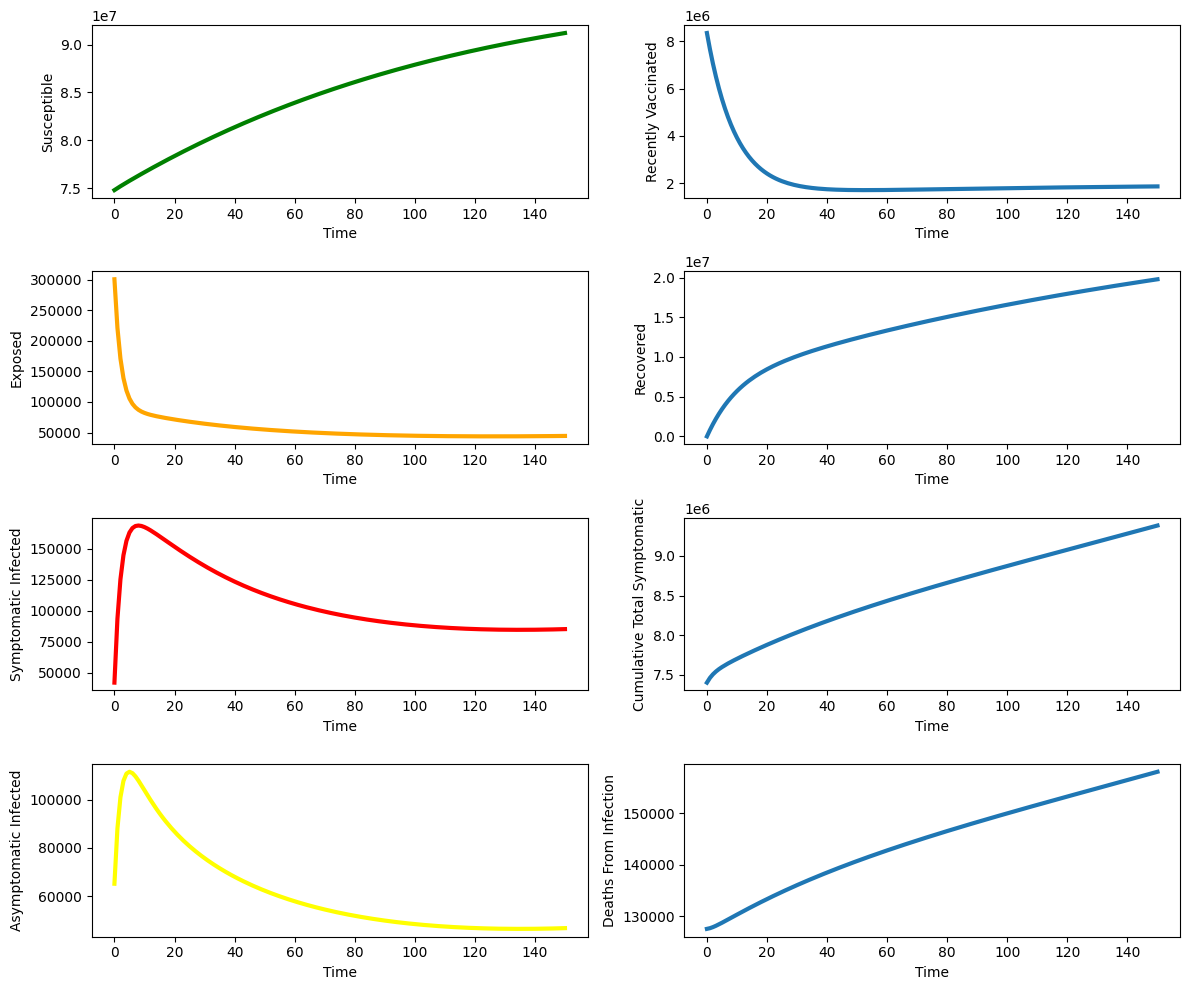

In [ ]:
# Our SEIAVR model

def modelcd(x, t1, b1, beta1, gammaa1, gammai1, gammava1, gammavi1, lambdaa1, lambdai1, mu1, mu_c1, nu1, phi1, sigma1, theta1):
    s, e, i, a, v, r, d, c = x


    dsdt = theta1-gammai1*s*i-nu1*b*s-gammaa1*s*a-mu1*s
    dedt = gammai1*s*i+gammaa1*s*a-beta1*e+gammavi1*v*i+gammava1*v*a-mu1*e
    didt = (1-sigma1)*beta1*e-mu_c1*i-lambdai1*i-mu1*i
    dadt = sigma1*beta1*e-lambdaa1*a-mu1*a
    dvdt = nu1*b1*s-phi1*v-gammavi1*v*i-gammava1*v*a-mu1*v
    drdt = lambdaa1*a+lambdai1*i+phi1*v-mu1*r
    dddt = mu_c1*i
    dcdt = (1-sigma1)*beta1*e
    return [dsdt, dedt, didt, dadt, dvdt, drdt, dddt, dcdt]

t = np.linspace(0, t_max, t_max+1)
x0 = s0, e0, i0, a0, v0, r0, d0, c0
soln = odeint(modelcd, x0, t, args=(*params,))
s, e, i, a, v, r, d, c = soln.T


def plotdata(t, s, e, i, a, v, r, d, c):
    # plot the data
    fig, ax=plt.subplots(4,2,figsize=(12,10))



    ax[0,0].plot(t, s, lw=3, label='Susceptible', color='green')
    ax[0,0].set_xlabel('Time');
    ax[0,0].set_ylabel('Susceptible');

    ax[1,0].plot(t, e, lw=3, label='Exposed', color='orange')
    ax[1,0].set_xlabel('Time');
    ax[1,0].set_ylabel('Exposed');

    ax[2,0].plot(t, i, lw=3, label='Symptomatic Infected', color='red')
    ax[2,0].set_xlabel('Time');
    ax[2,0].set_ylabel('Symptomatic Infected');

    ax[3,0].plot(t, a, lw=3, label='Asymptomatic Infected', color='yellow')
    ax[3,0].set_xlabel('Time');
    ax[3,0].set_ylabel('Asymptomatic Infected');

    ax[0,1].plot(t, v, lw=3, label='Recently Vaccinated')
    ax[0,1].set_xlabel('Time');
    ax[0,1].set_ylabel('Recently Vaccinated');

    ax[1,1].plot(t, r, lw=3, label='Recovered')
    ax[1,1].set_xlabel('Time');
    ax[1,1].set_ylabel('Recovered');

    ax[2,1].plot(t, c, lw=3, label='Cumultative Total Symptomatic')
    ax[2,1].set_xlabel('Time');
    ax[2,1].set_ylabel('Cumulative Total Symptomatic');

    ax[3,1].plot(t, d, lw=3, label='Deaths From Infection')
    ax[3,1].set_xlabel('Time');
    ax[3,1].set_ylabel('Deaths From Infection');



    plt.tight_layout()

plotdata(t, s, e, i, a, v, r, d, c)

In [ ]:
x0

(74785116.94285715,
 300380.79999999993,
 42158.85714285714,
 65119.99999999998,
 8347517.4,
 0,
 127500.0,
 7400000.0)

In [ ]:
#Parameter Estimation
import pandas as pd

import scipy.optimize as optimize
from scipy.optimize import least_squares
from scipy.stats import poisson
from scipy.stats import norm

In [ ]:
qdf = pd.read_csv('/content/drive/Shareddrives/QRLSSP 2024/COVID/Python Code/us-counties-2021.csv')
qdf['county'] = qdf['county'].str.lower()
qdf['state'] = qdf['state'].str.lower()
qdf['county_state'] = qdf['county'] + '-' + qdf['state']
print("Total counties including Alaska and Hawaii after concatenating state & county US counites:", len(qdf['county_state'].unique()))
qdf['date'] = pd.to_datetime(qdf['date'], errors='coerce')

qdf = qdf.dropna(subset=['date'])

start_date = '2021-03-01'
end_date = '2021-09-01'

date_filtered_data = qdf[(qdf['date'] >= start_date) & (qdf['date'] <= end_date)]

vdf = pd.read_csv('/content/drive/Shareddrives/QRLSSP 2024/COVID/Python Code/2020 Election Voting by County csv.csv')
vdf = vdf[~vdf['state'].isin(['alaska', 'hawaii'])]
vdf['name'] = vdf['name'].str.lower()
vdf['state'] = vdf['state'].str.lower()
vdf['name_state'] = vdf['name'] + '-' + vdf['state']
vdf['trumpd_votes_ratio'] = vdf['results_trumpd'] / vdf['votes']
print("Total counties including Alaska and Hawaii after concatenating state & county Voting:", len(vdf['name_state'].unique()))

Total counties including Alaska and Hawaii after concatenating state & county US counites: 3262
Total counties including Alaska and Hawaii after concatenating state & county Voting: 3115


In [ ]:
# Categorize counties into a1 to a5 based on Trump vote ratios
a1, a2, a3, a4, a5 = [], [], [], [], []

for _, row in vdf.iterrows():
    county = row['fips']
    ratio = row['trumpd_votes_ratio']
    if ratio <= 0.25:
        a1.append(county)
    elif 0.25 <= ratio < 0.45:
        a2.append(county)
    elif 0.45 <= ratio < 0.55:
        a3.append(county)
    elif 0.55 <= ratio < 0.75:
        a4.append(county)
    else:
        a5.append(county)

# Print counts of counties in each category
print("a1:", len(a1))
print("a2:", len(a2))
print("a3:", len(a3))
print("a4:", len(a4))
print("a5:", len(a5))
print("Total Counites:",len(a1)+len(a2)+len(a3)+len(a4)+len(a5))

a1: 62
a2: 355
a3: 330
a4: 1385
a5: 983
Total Counites: 3115


In [ ]:
def aggregate_category_data(category, category_counties):
    # Filter COVID-19 data for counties in the category
    category_data = date_filtered_data[date_filtered_data['fips'].isin(category_counties)]

    # Group by date and aggregate cases and deaths
    category_aggregated = category_data.groupby('date').agg({'cases': 'sum', 'deaths': 'sum'}).reset_index()

    # Return the aggregated data
    return category_aggregated

# Aggregate data for each category
category_a1_data = aggregate_category_data('a1', a1)
category_a2_data = aggregate_category_data('a2', a2)
category_a3_data = aggregate_category_data('a3', a3)
category_a4_data = aggregate_category_data('a4', a4)
category_a5_data = aggregate_category_data('a5', a5)

# Now you can access the aggregated data for each category
print(category_a1_data.head())
print(category_a2_data.head())
print(category_a3_data.head())
print(category_a4_data.head())
print(category_a5_data.head())


        date    cases   deaths
0 2021-03-01  1655613  32261.0
1 2021-03-02  1658001  32357.0
2 2021-03-03  1661465  32478.0
3 2021-03-04  1665006  32566.0
4 2021-03-05  1668306  32629.0
        date     cases    deaths
0 2021-03-01  11158967  194746.0
1 2021-03-02  11182148  195384.0
2 2021-03-03  11209293  196360.0
3 2021-03-04  11235460  197215.0
4 2021-03-05  11260993  198195.0
        date    cases   deaths
0 2021-03-01  5554198  89576.0
1 2021-03-02  5566852  89877.0
2 2021-03-03  5580508  90271.0
3 2021-03-04  5593619  90598.0
4 2021-03-05  5607018  91005.0
        date    cases    deaths
0 2021-03-01  7394784  127763.0
1 2021-03-02  7407994  127938.0
2 2021-03-03  7424610  128524.0
3 2021-03-04  7440441  129028.0
4 2021-03-05  7455677  129816.0
        date    cases   deaths
0 2021-03-01  1844362  35454.0
1 2021-03-02  1846091  35488.0
2 2021-03-03  1849820  35652.0
3 2021-03-04  1853531  35760.0
4 2021-03-05  1856346  35929.0


In [ ]:
category_a1_data

,date,cases,deaths
0,2021-03-01,1655613,32261.0
1,2021-03-02,1658001,32357.0
2,2021-03-03,1661465,32478.0
3,2021-03-04,1665006,32566.0
4,2021-03-05,1668306,32629.0
...,...,...,...
180,2021-08-28,2177504,38057.0
181,2021-08-29,2179686,38061.0
182,2021-08-30,2190782,38083.0
183,2021-08-31,2196041,38121.0


In [ ]:
times_list = np.zeros((int(t[len(t)-1]),5))
case_data_list = np.zeros((int(t[len(t)-1]),5))
death_data_list = np.zeros((int(t[len(t)-1]),5))

times_list[:,0]= category_a1_data['date'].index[0:t_max] #time data points a1
case_data_list[:,0] = category_a1_data['cases'][0:t_max] #cases data points a1
death_data_list[:,0] = category_a1_data['deaths'][0:t_max] #deaths data points a1

times_list[:,1]= category_a2_data['date'].index[0:t_max] #time data points a2
case_data_list[:,1] = category_a2_data['cases'][0:t_max] #cases data points a2
death_data_list[:,1] = category_a2_data['deaths'][0:t_max] #deaths data points a2

times_list[:,2]= category_a3_data['date'].index[0:t_max] #time data points a3
case_data_list[:,2] = category_a3_data['cases'][0:t_max] #cases data points a3
death_data_list[:,2] = category_a3_data['deaths'][0:t_max] #deaths data points a3

times_list[:,3]= category_a4_data['date'].index[0:t_max] #time data points a4
case_data_list[:,3] = category_a4_data['cases'][0:t_max] #cases data points a4
death_data_list[:,3] = category_a4_data['deaths'][0:t_max] #deaths data points a4

times_list[:,4]= category_a5_data['date'].index[0:t_max] #time data points a5
case_data_list[:,4] = category_a5_data['cases'][0:t_max] #cases data points a5
death_data_list[:,4] = category_a5_data['deaths'][0:t_max] #deaths data points a5





In [ ]:
times = times_list[:,j-1] # choose subpopulations of interest
case_data = case_data_list[:,j-1]
death_data = death_data_list[:,j-1]

T = times

In [ ]:
#Do a nonlinear least squares fit to synthetic exponential growth model
#######################

#Get our functions first:
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [ ]:
def run_nlsfit(x0, params, T, Y):
    #params is vector of parameters
    #t is time, Y is data
    #Will have y0 as first parameter, alpha as second

    #Run the model
    x_model = odeint(modelcd, x0, T, args=(*params,))

    #Return the residuals
    #Calculate, need to reshape from (N,1) array to (N) array
    #It's just the format least_squares expects

    resc = case_data - x_model[:,7]
    resd = death_data - x_model[:,6]

    resc = resc.reshape(len(resc),)
    resd = resd.reshape(len(resd),)

    return (resc, resd)

In [ ]:
num_rho = 1000

rho_val = np.linspace(.1,.25, num_rho)

#Array for error values
E_C = np.zeros([num_rho,1])
E_D = np.zeros([num_rho,1])
E_T = np.zeros([num_rho,1])




for k in range(num_rho):

    params[3] = rho_val[k]/N
    params[2] = params[3]*.8
    params[5] = params[3]*(1-alpha)
    params[4] = params[2]*(1-alpha)
    X_model = odeint(modelcd, x0, T, args=(*params,))
    E_C[k] = np.sum((X_model[:,7] - case_data)**2)
    E_D[k] = np.sum((X_model[:,6] - death_data)**2)
    E_T[k] = E_C[k]+E_D[k]

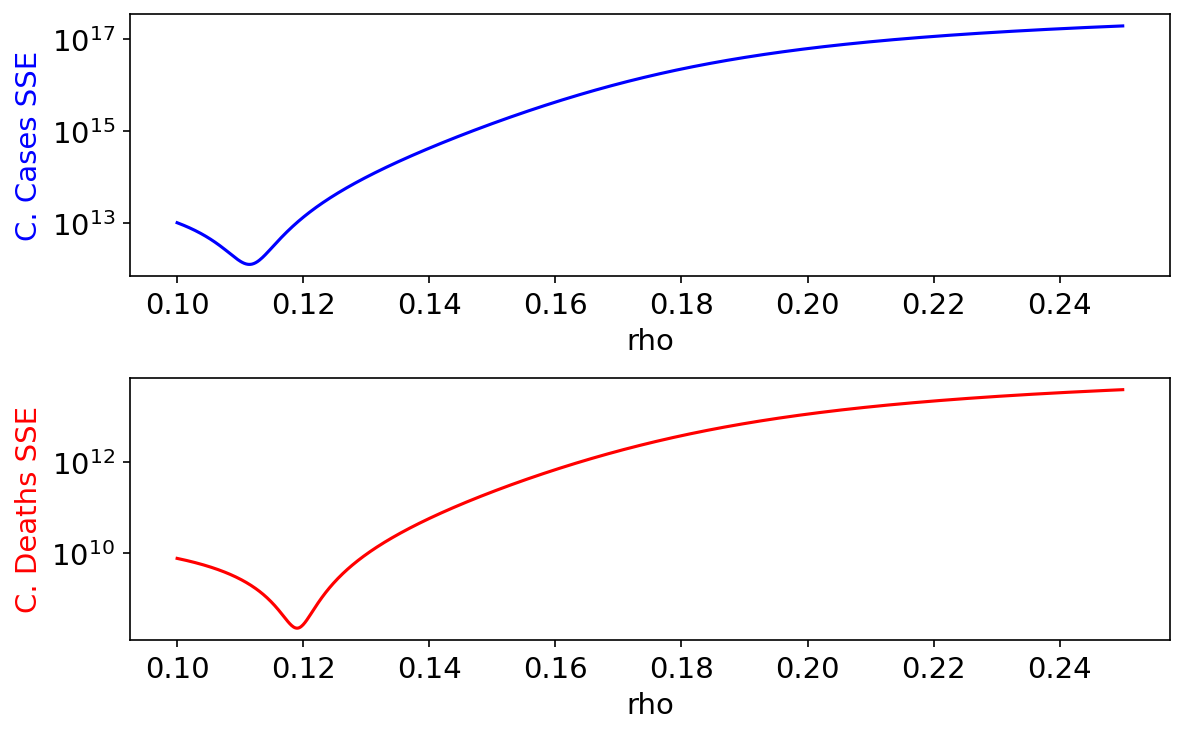

In [ ]:
fig, ax1 = plt.subplots(2, 1, figsize=(8,5), dpi = 150)
ax1[0].plot(rho_val, E_C, color = 'blue')
ax1[1].plot(rho_val, E_D, color = 'red')

#Note that we set our scale to be logarithmic:
ax1[0].set_yscale('log')
ax1[1].set_yscale('log')

#Plus some aesthetics
fs=14
ax1[0].set_xlabel('rho', fontsize = fs)
ax1[0].set_ylabel('C. Cases SSE', fontsize = fs, color = 'blue')

ax1[1].set_xlabel('rho', fontsize = fs)
ax1[1].set_ylabel('C. Deaths SSE', fontsize = fs, color = 'red')

ax1[0].tick_params(axis='both', which='major', labelsize=fs)
ax1[1].tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()

In [ ]:
indexc = np.argmin(E_C)
indexd = np.argmin(E_D)

print("The estimated rho for cases for a",j, " is ", rho_val[indexc])
print("The estimated rho for deaths for a",j," is ", rho_val[indexd])

The estimated rho for cases for a 4  is  0.11141141141141142
The estimated rho for deaths for a 4  is  0.11906906906906907


In [ ]:
rho_val[indexd]-rho_val[indexc]

0.007657657657657649

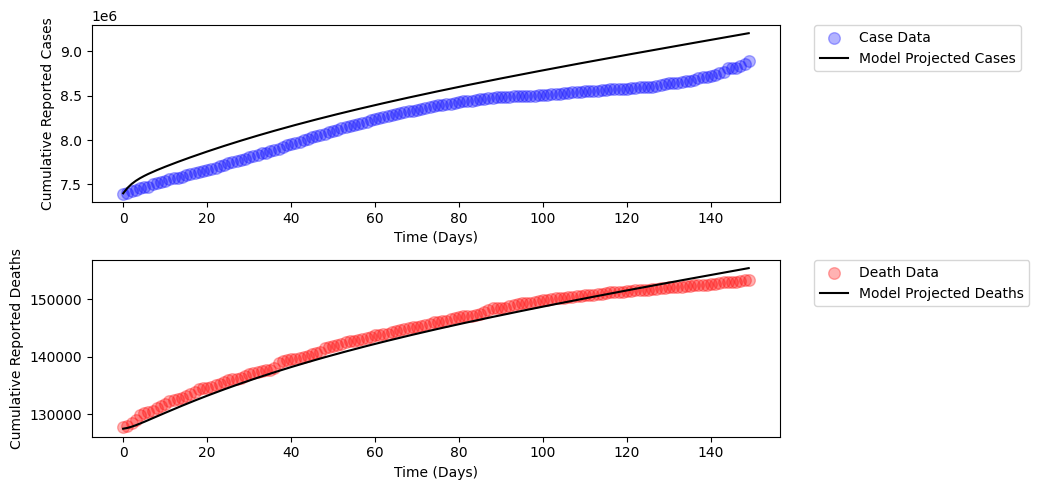

In [ ]:
rho = rho_val[indexd]

params = [b, beta, rho/N*.8, rho/N, rho/N*.8*(1-alpha), rho/N*(1-alpha), lambdaa, lambdai, mu, mu_c, nu, phi, sigma, theta]


X = odeint(modelcd, x0, times, args=(*params,))




#Plot...
fig, ax1 = plt.subplots(2, 1, figsize=(8,5))

ax1[0].scatter(T, case_data, c='blue', s = 70, alpha=.3, label = "Case Data")
ax1[0].plot(T, X[:,7], c='black', label = "Model Projected Cases")
ax1[1].scatter(T, death_data, c='red', s = 70, alpha=.3, label = "Death Data")
ax1[1].plot(T, X[:,6], c='black', label = "Model Projected Deaths")
ax1[0].set_xlabel('Time (Days)')
ax1[1].set_xlabel('Time (Days)')
ax1[0].set_ylabel('Cumulative Reported Cases')
ax1[1].set_ylabel('Cumulative Reported Deaths')

fig.tight_layout()
ax1[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax1[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
resc, resd = run_nlsfit(x0, params, T, X)

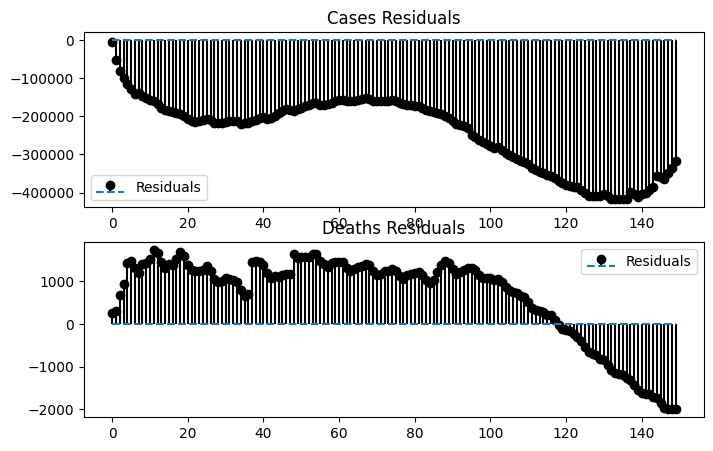

In [ ]:
fig1, ax2 = plt.subplots(2, 1, figsize=(8,5))

ax2[0].stem(T, resc, basefmt = '--', markerfmt = 'ko', linefmt = 'k-', label='Residuals')
ax2[0].legend()
ax2[0].set_title('Cases Residuals');

ax2[1].stem(T, resd, basefmt = '--', markerfmt = 'ko', linefmt = 'k-', label='Residuals')
ax2[1].legend()
ax2[1].set_title('Deaths Residuals');

In [ ]:
#R0


gammai = rho/N
gammaa = gammai*.8
gammavi = gammai*(1-alpha)
gammava = gammaa*(1-alpha)

denS = mu + b*nu
denE = beta + mu
denI = lambdai + mu + mu_c
denA = lambdaa + mu
denV = mu + phi

In [ ]:
R0 = -beta*theta*(b*nu*(gammavi*(lambdaa+mu)*(sigma-1)-gammava*(lambdai+mu+mu_c)*sigma)+gammai*(lambdaa+mu)*(sigma-1)*(mu+phi)-gammaa*(lambdai+mu+mu_c)*sigma*(mu+phi))/(denS*denE*denI*denA*denV)

In [ ]:
def findR0(rhotest):

  rho = rhotest

  gammai = rhotest/N
  gammaa = gammai*.8
  gammavi = gammai*(1-alpha)
  gammava = gammaa*(1-alpha)

  R0 = beta*theta*((1-sigma)*(b*nu*gammavi/(denE*denI*denS*denV)+gammai/(denE*denS*denI))+sigma*(b*nu*gammava/(denE*denA*denS*denV)+gammaa/(denE*denA*denS)))

  return R0

In [ ]:
R0

1.0731980915319759

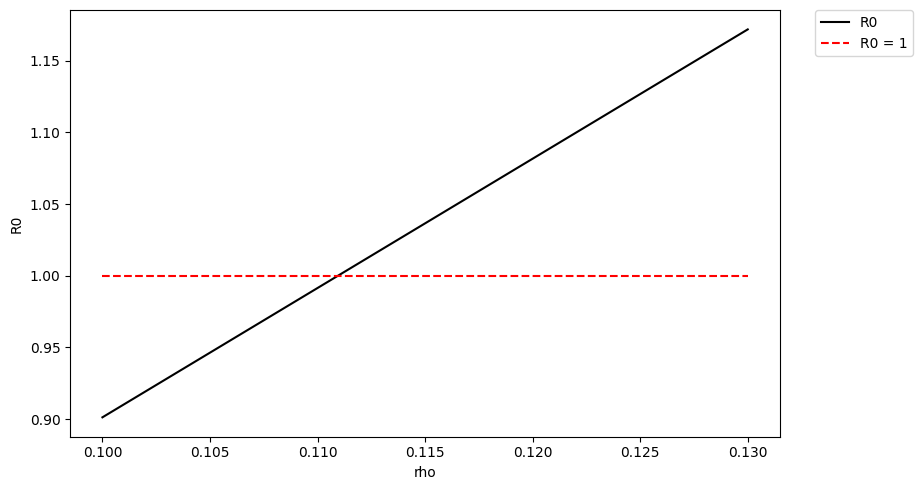

In [ ]:
fig, ax2 = plt.subplots(1, 1, figsize=(8,5))

num_rho = 500

rho_val = np.linspace(.1,.13, num_rho)
R0_val = findR0(rho_val)
one_val = np.linspace(1,1,num_rho)

ax2.plot(rho_val, R0_val, c='black', label = "R0")
ax2.plot(rho_val, one_val, c = 'red', label = "R0 = 1", linestyle = 'dashed')
ax2.set_xlabel('rho')
ax2.set_ylabel('R0')

fig.tight_layout()
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)